# Gold Recovery from Ore

**Prepare a Machine Learning Model Prototype for "Digits". The company develops solutions for the efficient operation of industrial enterprises.**

**Goals:**
1. The model should predict the gold recovery rate from gold-containing ore.
2. The model will help optimize production to avoid running the plant with unprofitable characteristics.

## Data Preparation

In [1]:
import pandas as pd
from sklearn.metrics import (mean_absolute_error, 
                             mean_absolute_percentage_error, 
                             make_scorer)
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import collections
from sklearn.dummy import DummyRegressor


In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
 data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
# rougher.output.concentrate_au - fraction of gold after flotation
# rougher.input.feed_au - fraction of gold in the substance before flotation
# rougher.output.tail_au - fraction of gold in the tail after flotation
# Function to calculate recovery
def recovery(C, F, T):
    recover = ((C * (F - T)) / (F * (C - T))) * 100
    return recover

In [5]:
# Let's check for missing values in the columns
data_train.loc[:, ['rougher.output.concentrate_au', 
                   'rougher.output.tail_au', 
                   'rougher.input.feed_au', 'rougher.output.recovery']].isna().sum()

rougher.output.concentrate_au    0
rougher.output.tail_au           0
rougher.input.feed_au            0
rougher.output.recovery          0
dtype: int64

In [6]:
# Apply the function
calculate_recovery = recovery(data_train['rougher.output.concentrate_au'], 
                              data_train['rougher.input.feed_au'], 
                              data_train['rougher.output.tail_au'])
calculate_recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

In [7]:
print(mean_absolute_error(data_train['rougher.output.recovery'], calculate_recovery))

9.73512347450521e-15


The recovery was calculated correctly.

In [8]:
# Checking for columns that are missing in `data_test`
stage = collections.Counter()
type_parameters = collections.Counter()
parameters = collections.Counter()

data_columns = [i for i in data_train.columns if i not in data_test.columns]
for i in data_columns:
    word = list(map(str, i.split('.')))
    stage[word[0]] += 1
    type_parameters[word[1]] += 1
    parameters[word[2]] += 1

In [9]:
data_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [10]:
stage, '\n', type_parameters, '\n', parameters

(Counter({'final': 9,
          'primary_cleaner': 8,
          'rougher': 13,
          'secondary_cleaner': 4}),
 '\n',
 Counter({'output': 30, 'calculation': 4}),
 '\n',
 Counter({'concentrate_ag': 3,
          'concentrate_pb': 3,
          'concentrate_sol': 3,
          'concentrate_au': 3,
          'recovery': 2,
          'tail_ag': 4,
          'tail_pb': 4,
          'tail_sol': 4,
          'tail_au': 4,
          'sulfate_to_au_concentrate': 1,
          'floatbank10_sulfate_to_au_feed': 1,
          'floatbank11_sulfate_to_au_feed': 1,
          'au_pb_ratio': 1}))

We have raw data at our disposal, which was directly extracted from the storage. The test sample was collected under operating conditions, so some features have not yet been measured and calculated. Let's investigate the missing features.

There are 9 stages of final characterization, 8 stages of primary cleaning, 13 stages of flotation, and 4 stages of secondary cleaning missing in the test sample. All types of output and calculation parameters are absent. Among the parameters: all parameters responsible for the concentration of substances at the output, including gold, all parameters responsible for tails, target parameters, and other calculated parameters are missing. All these parameters are unknown to us at the start of the model operation.

By excluding all the missing columns in the test sample from the training data, we can obtain an approximate list of columns for features.

In [11]:
# Checking for duplicates
data_train.duplicated().sum(), data_test.duplicated().sum()

(0, 0)

In [12]:
data_train_nodate = data_train.drop('date', axis = 1)
data_test_nodate = data_test.drop('date', axis = 1)
data_train_nodate.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

No duplicates found. I will conduct further data preparation in the "Data Analysis" block to retain as much data as possible for training.

## Data Analysis

In [13]:
data_full_filtered = data_full.drop('date', axis = 1)
plt.rcParams["figure.figsize"] = (20,10)

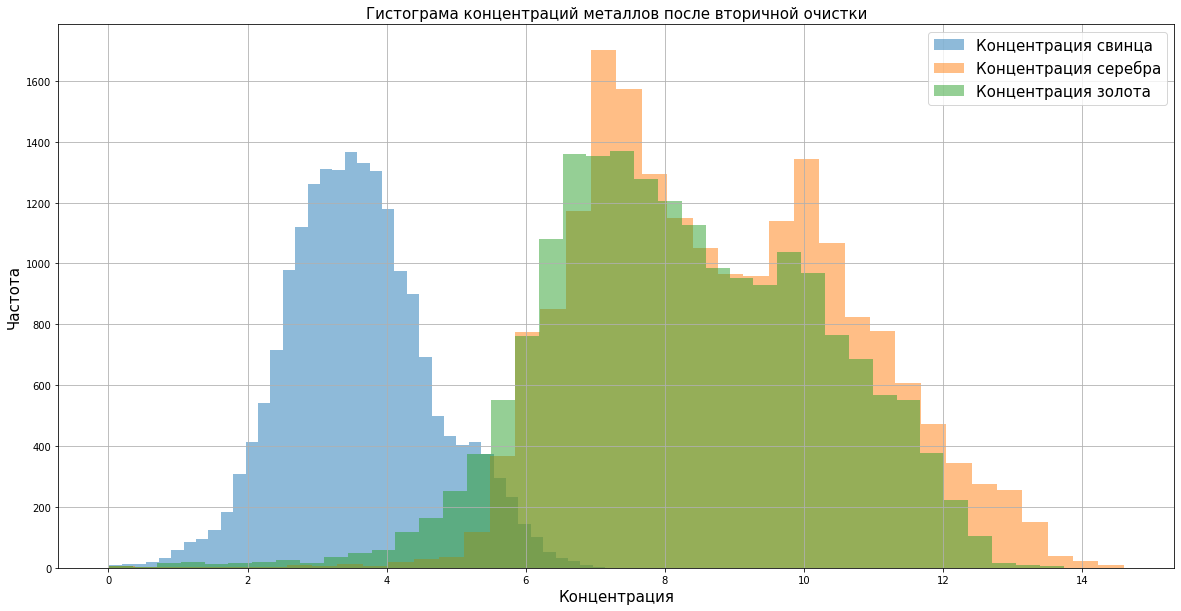

In [14]:
data_full['rougher.input.feed_pb'].hist(alpha=0.5, label='Концентрация свинца', bins=40)
data_full['rougher.input.feed_ag'].hist(alpha=0.5, label='Концентрация серебра', bins=40)
data_full['rougher.input.feed_au'].hist(alpha=0.5, label='Концентрация золота', bins=40)
plt.legend(prop={'size':15})
plt.xlabel('Концентрация', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограма концентраций металлов после вторичной очистки', fontsize=15);

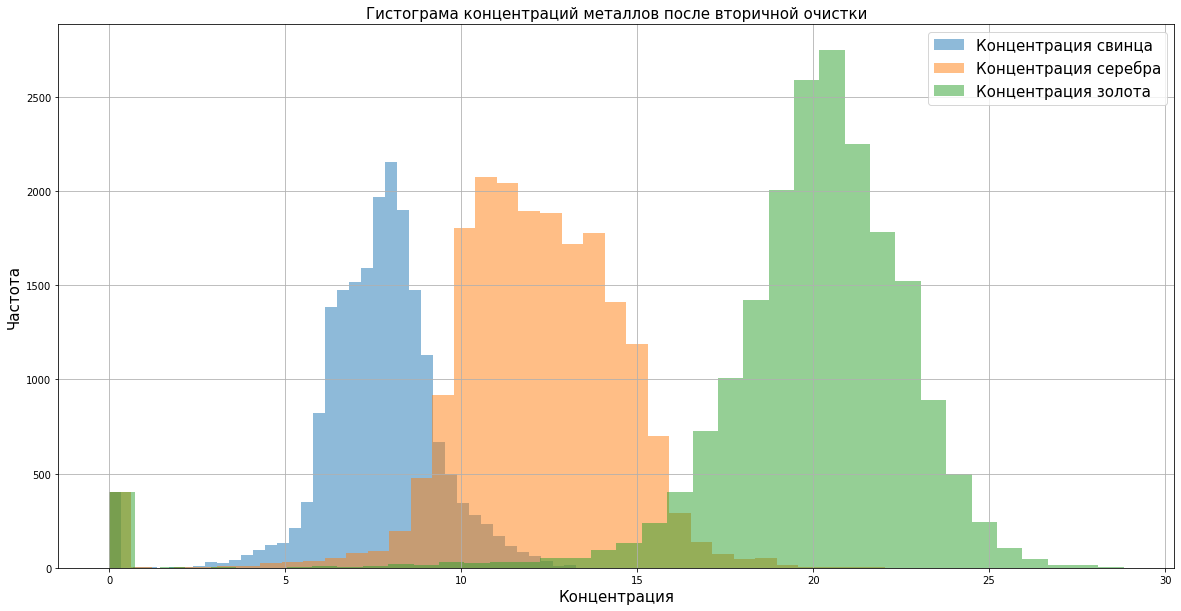

In [15]:
data_full['rougher.output.concentrate_pb'].hist(alpha=0.5, label='Концентрация свинца', bins=40)
data_full['rougher.output.concentrate_ag'].hist(alpha=0.5, label='Концентрация серебра', bins=40)
data_full['rougher.output.concentrate_au'].hist(alpha=0.5, label='Концентрация золота', bins=40)
plt.legend(prop={'size':15})
plt.xlabel('Концентрация', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограма концентраций металлов после вторичной очистки', fontsize=15);

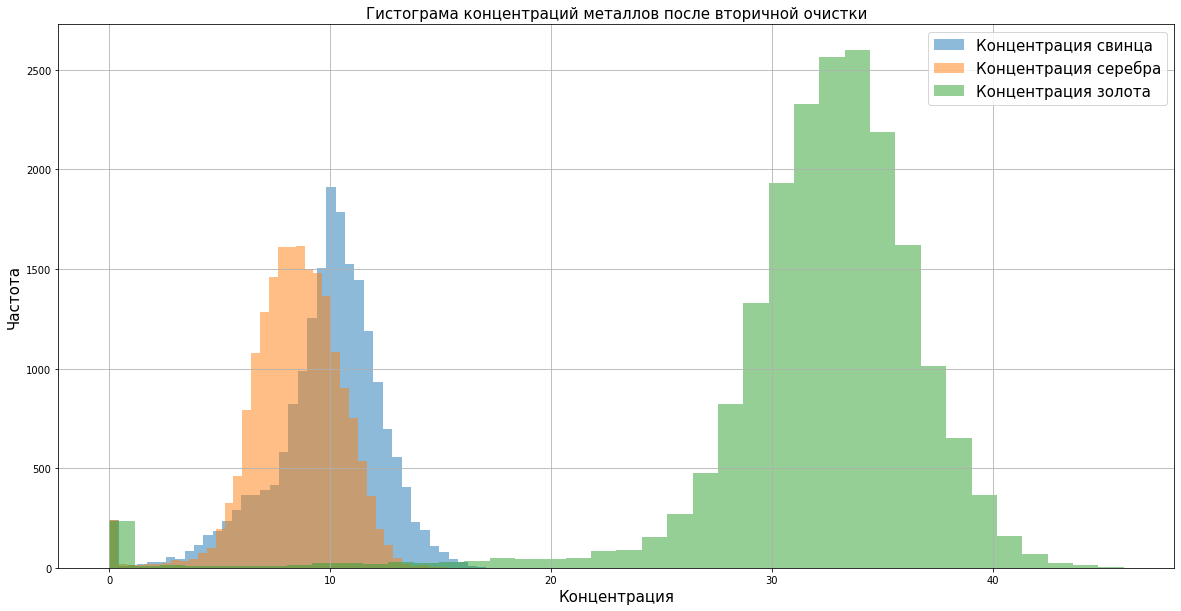

In [16]:
data_full['primary_cleaner.output.concentrate_pb'].hist(alpha=0.5, label='Концентрация свинца', bins=40)
data_full['primary_cleaner.output.concentrate_ag'].hist(alpha=0.5, label='Концентрация серебра', bins=40)
data_full['primary_cleaner.output.concentrate_au'].hist(alpha=0.5, label='Концентрация золота', bins=40)
plt.legend(prop={'size':15})
plt.xlabel('Концентрация', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограма концентраций металлов после вторичной очистки', fontsize=15);

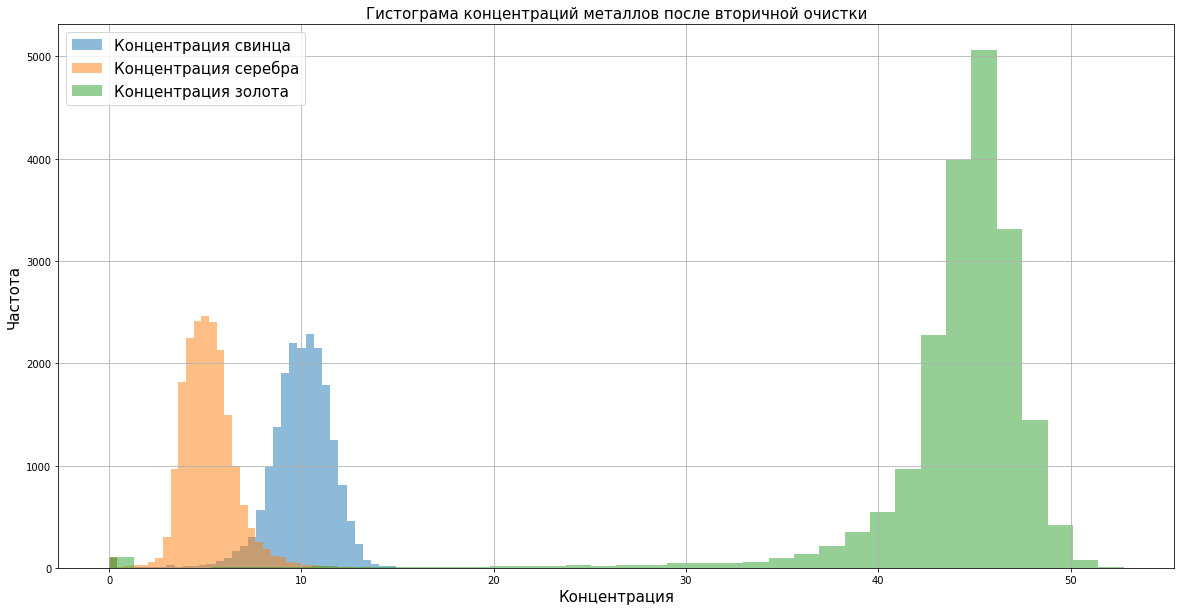

In [17]:
data_full['final.output.concentrate_pb'].hist(alpha=0.5, label='Концентрация свинца', bins=40)
data_full['final.output.concentrate_ag'].hist(alpha=0.5, label='Концентрация серебра', bins=40)
data_full['final.output.concentrate_au'].hist(alpha=0.5, label='Концентрация золота', bins=40)
plt.legend(prop={'size':15})
plt.xlabel('Концентрация', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('Гистограма концентраций металлов после вторичной очистки', fontsize=15);

In [18]:
# To begin with, let's calculate the fractions of metals in the substrate at all stages of purification
print('Концентрация металлов до флотации:')
print("Концентрация серебра:{: 0.2f}, концентрация свинца:{: 0.2f}, концентрация золота:{: 0.2f}".
format(data_full_filtered['rougher.input.feed_ag'].mean(),
data_full_filtered['rougher.input.feed_pb'].mean(),
data_full_filtered['rougher.input.feed_au'].mean()))
print()
print('Концентрация металлов после флотации:')
print('Концентрация серебра: {:0.2f}, концентрация свинца: {:0.2f}, концентрация золота: {:0.2f}'.
format(data_full_filtered['rougher.output.concentrate_ag'].mean(),
data_full_filtered['rougher.output.concentrate_pb'].mean(),
data_full_filtered['rougher.output.concentrate_au'].mean()))
print()
print('Концентрация металлов после первичной очистки:')
print('Концентрация серебра: {:0.2f}, концентрация свинца: {:0.2f}, концентрация золота: {:0.2f}'.
format(data_full_filtered['primary_cleaner.output.concentrate_ag'].mean(),
data_full_filtered['primary_cleaner.output.concentrate_pb'].mean(),
data_full_filtered['primary_cleaner.output.concentrate_au'].mean()))
print()
print('Концентрация металлов после вторичной очистки:')
print('Концентрация серебра: {:0.2f}, концентрация свинца: {:0.2f}, концентрация золота: {:0.2f}'.
format(data_full_filtered['final.output.concentrate_ag'].mean(),
data_full_filtered['final.output.concentrate_pb'].mean(),
data_full_filtered['final.output.concentrate_au'].mean()))

Концентрация металлов до флотации:
Концентрация серебра: 8.79, концентрация свинца: 3.60, концентрация золота: 8.27

Концентрация металлов после флотации:
Концентрация серебра: 11.99, концентрация свинца: 7.61, концентрация золота: 19.77

Концентрация металлов после первичной очистки:
Концентрация серебра: 8.44, концентрация свинца: 9.83, концентрация золота: 32.12

Концентрация металлов после вторичной очистки:
Концентрация серебра: 5.17, концентрация свинца: 9.98, концентрация золота: 44.08


We observe a consistent process of increasing the gold fraction and decreasing the fraction of other metals, except for lead. Its fraction increases, which is most likely related to the specific characteristics of the gold purification process.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


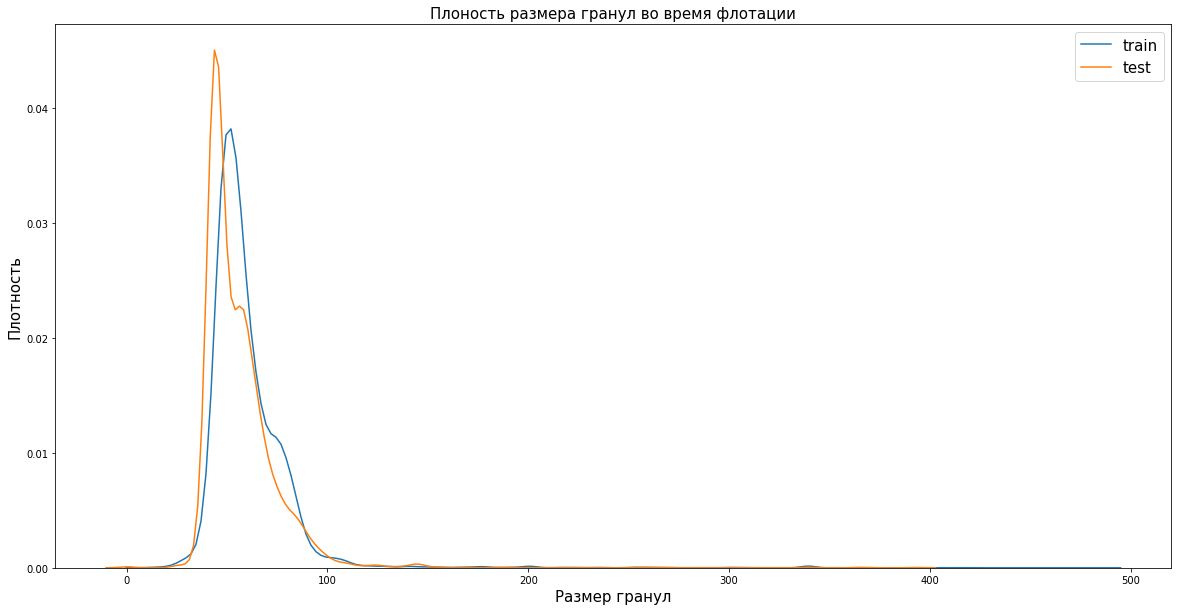

In [19]:
# Let's compare the particle sizes
plt.rcParams["figure.figsize"] = (20,10)
for frame, name in zip([data_train_nodate, data_test_nodate], 
                       ['train', 'test']):
    subset = frame['rougher.input.feed_size']
    sns.distplot(subset, hist=False, kde=True, label=name)

plt.legend(prop={'size': 15})
plt.title('Плоность размера гранул во время флотации', fontsize=15)
plt.xlabel('Размер гранул', fontsize=15)
plt.ylabel('Плотность', fontsize=15);

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


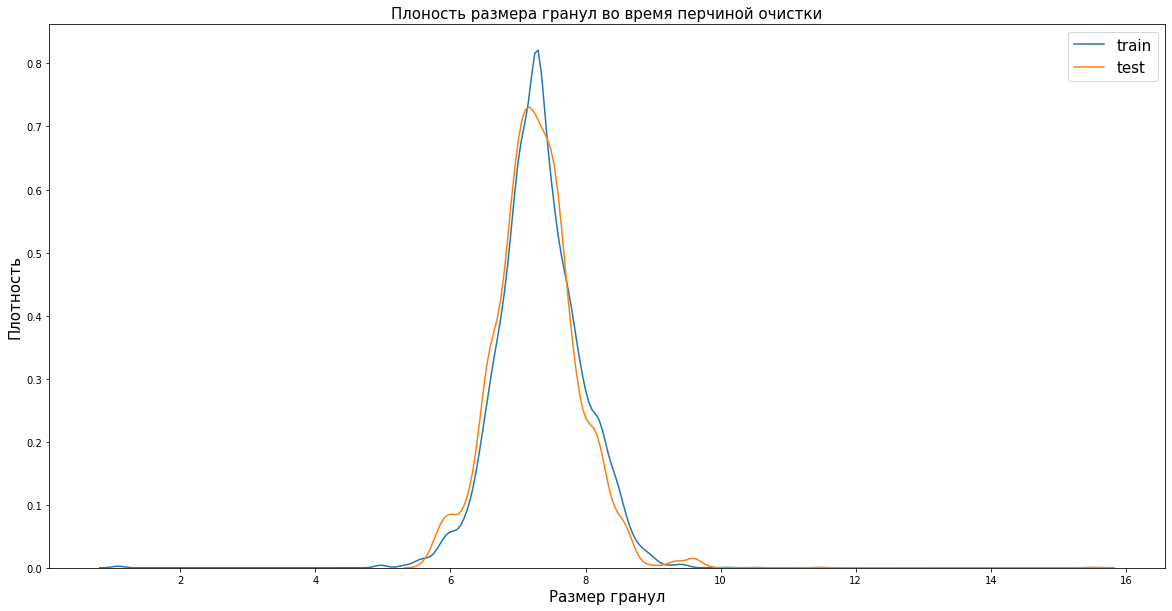

In [20]:
# Сравним размеры частиц
plt.rcParams["figure.figsize"] = (20,10)
for frame, name in zip([data_train_nodate, data_test_nodate], 
                       ['train', 'test']):
    subset = frame['primary_cleaner.input.feed_size']
    sns.distplot(subset, hist=False, kde=True, label=name)

plt.legend(prop={'size': 15})
plt.title('Размер гранул');
plt.title('Плоность размера гранул во время перчиной очистки', fontsize=15)
plt.xlabel('Размер гранул', fontsize=15)
plt.ylabel('Плотность', fontsize=15);

The curves overlap, indicating that the particle size in the training set is similar to the particle size in the test set.

In [21]:
def sum_ration(data):
    df = pd.Series(data.index, name='0')
    list_column_new = []
    list_column = ['final.output.concentrate_', 'primary_cleaner.output.concentrate_',
                   'rougher.output.concentrate_', 'rougher.input.feed_']
    list_metal = ['au', 'pb', 'ag', 'sol']
    for columns in list_column:
        columns = [columns] * 4
        for column, metal in zip(columns, list_metal):
            list_column_new.append(column+metal)
    for i in range(0, len(list_column_new), 4):
        col = list_column_new[i:i+4]
        data_sum = pd.Series(data.loc[: , col].sum(axis=1), name=str(i+3))
        df = pd.concat([df, data_sum], axis=1)
    df.columns = ['indexes', 'final.output', 'primary_cleaner', 'rougher.output', 'rougher.input']
    return df

In [22]:
df = sum_ration(data_train)
df

,indexes,final.output,primary_cleaner,rougher.output,rougher.input
0,0,63.644396,72.640924,66.424950,51.680034
1,1,63.957723,72.543485,67.012710,50.659114
2,2,64.311180,72.095042,66.103793,50.609929
3,3,63.573449,59.957723,65.752751,51.061546
4,4,64.004667,71.321010,65.908382,47.859163
...,...,...,...,...,...
14144,14144,68.098589,59.001692,70.781325,53.415050
14145,14145,68.274362,59.703912,70.539603,53.696482
14146,14146,68.226068,59.561096,55.376330,54.589604
14147,14147,68.200449,57.216686,69.201689,54.027355


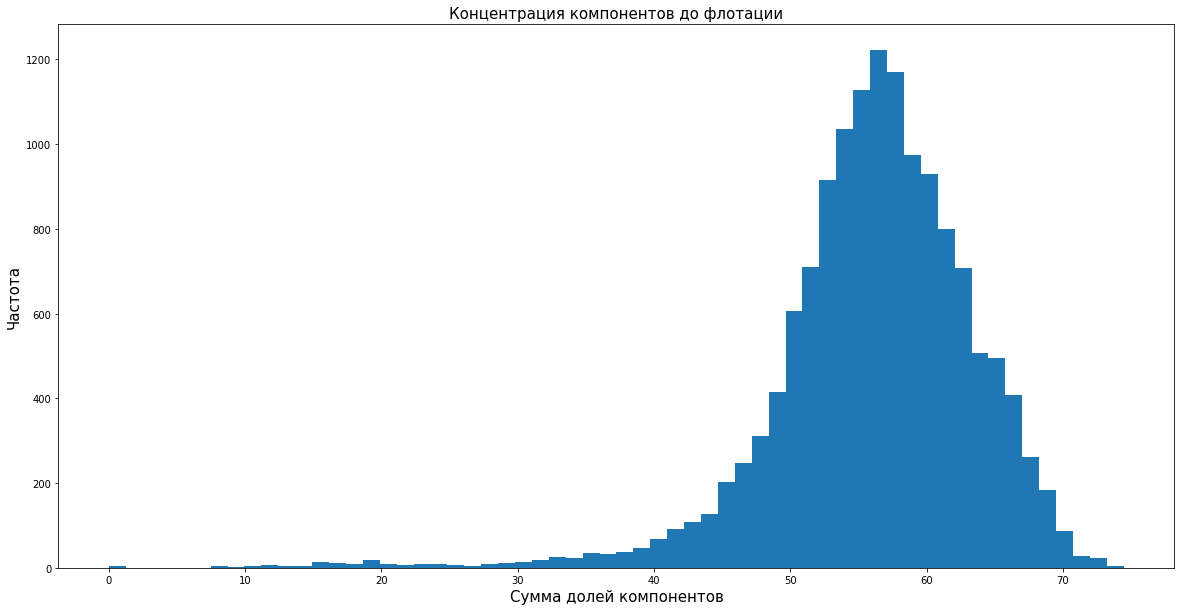

In [23]:
plt.hist(df['rougher.input'], bins=60)
plt.xlabel("Сумма долей компонентов", fontsize=15)
plt.title('Концентрация компонентов до флотации', fontsize=15)
plt.ylabel('Частота', fontsize=15);

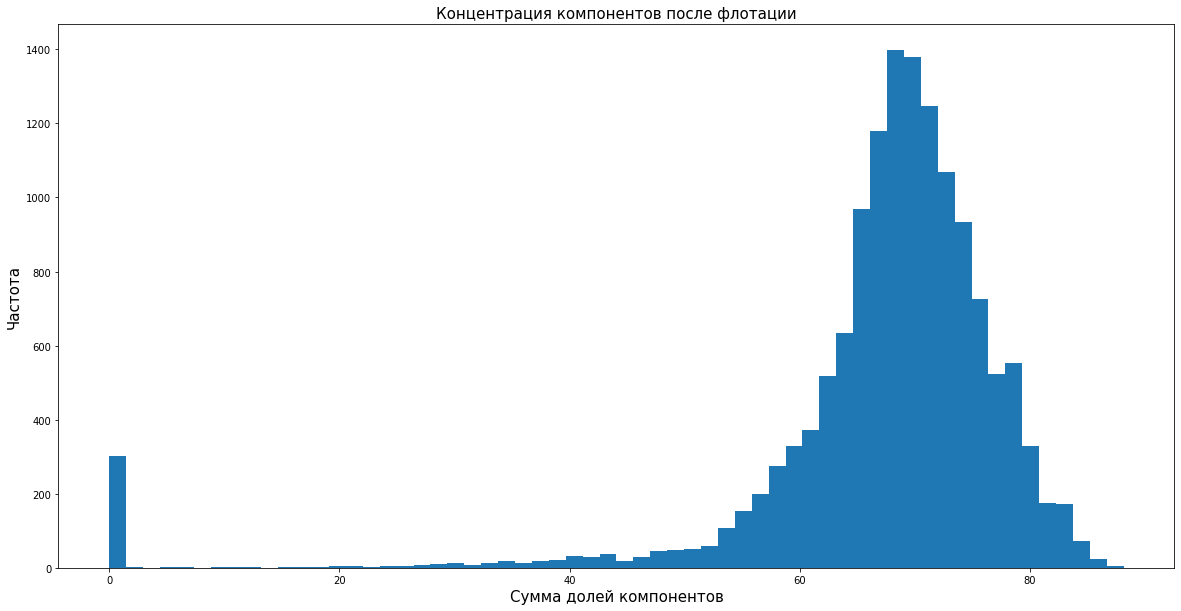

In [24]:
plt.hist(df['rougher.output'], bins=60)
plt.xlabel("Сумма долей компонентов", fontsize=15)
plt.title('Концентрация компонентов после флотации', fontsize=15)
plt.ylabel('Частота', fontsize=15);

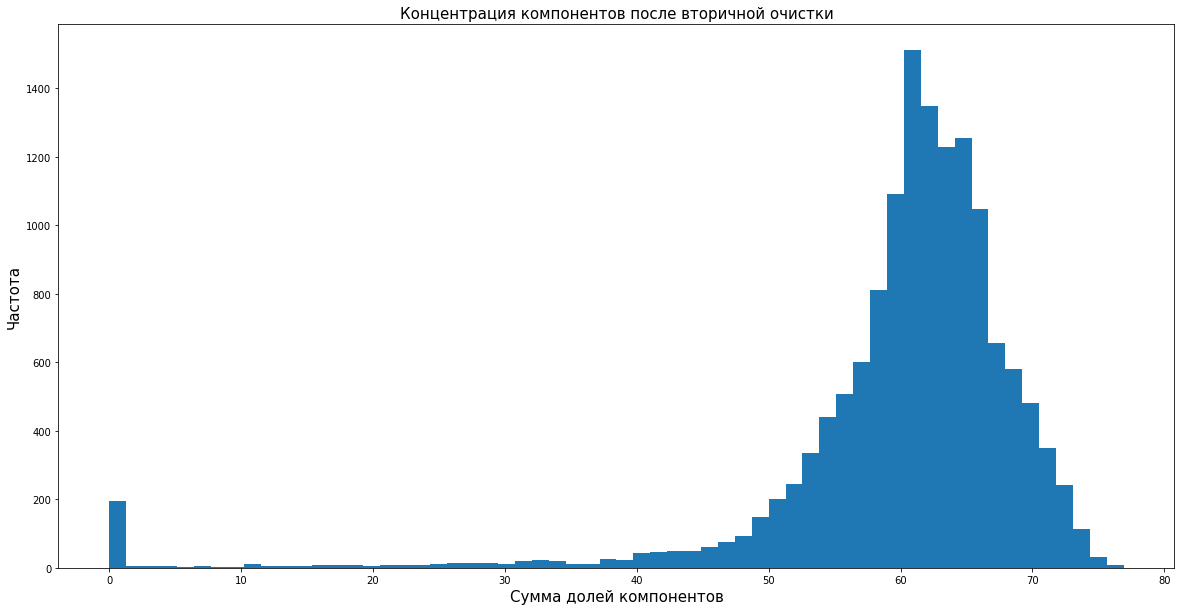

In [25]:
plt.hist(df['primary_cleaner'], bins=60)
plt.xlabel("Сумма долей компонентов", fontsize=15)
plt.title('Концентрация компонентов после вторичной очистки', fontsize=15)
plt.ylabel('Частота', fontsize=15);

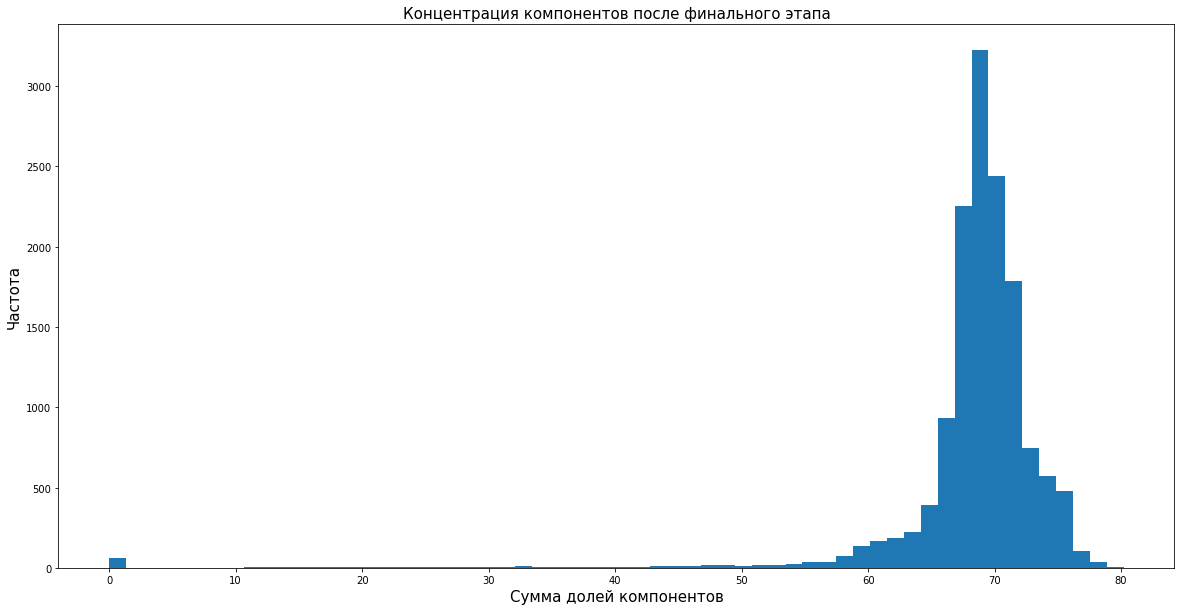

In [26]:
plt.hist(df['final.output'], bins=60)
plt.xlabel("Сумма долей компонентов", fontsize=15)
plt.title('Концентрация компонентов после финального этапа', fontsize=15)
plt.ylabel('Частота', fontsize=15);

All histograms exhibit a normal distribution, and we observe a narrowing of the distribution of concentrations of all substances during the gold-bearing ore purification process. This indicates that regardless of the initial raw material composition, the final concentration tends to converge to an average value. Outliers are present in the distribution. Let's try to eliminate them.

In [27]:
# Let's use a function to remove outliers
def remove_outliers_zscore(dataframe, threshold=5):
    z_scores = np.abs((dataframe - dataframe.mean()) / dataframe.std())
    mask = z_scores > threshold
    return dataframe[~mask.any(axis=1)].reset_index(drop=True)

In [28]:
df = sum_ration(remove_outliers_zscore(data_train))

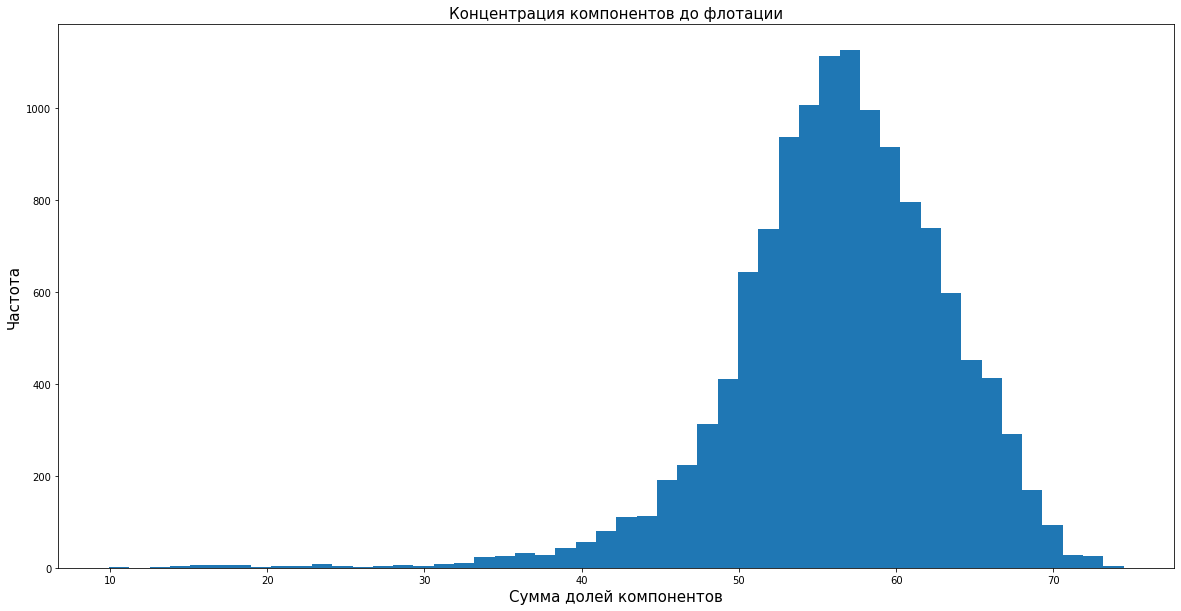

In [29]:
plt.hist(df['rougher.input'], bins=50)
plt.xlabel("Сумма долей компонентов", fontsize=15)
plt.title('Концентрация компонентов до флотации', fontsize=15)
plt.ylabel('Частота', fontsize=15);

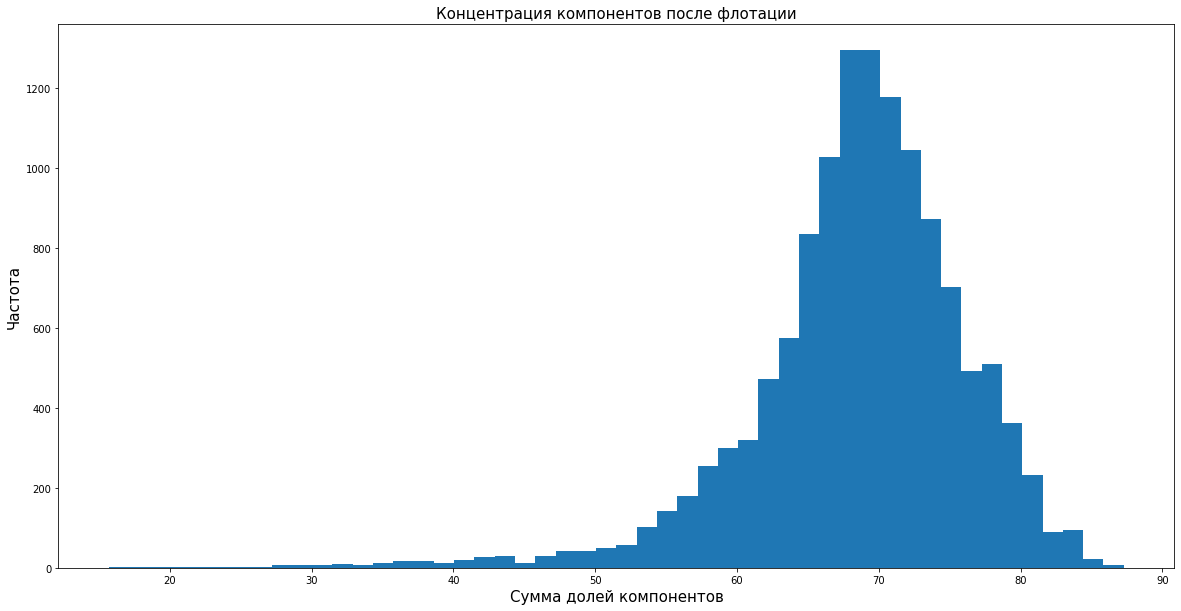

In [30]:
plt.hist(df['rougher.output'], bins=50)
plt.xlabel("Сумма долей компонентов", fontsize=15)
plt.title('Концентрация компонентов после флотации', fontsize=15)
plt.ylabel('Частота', fontsize=15);

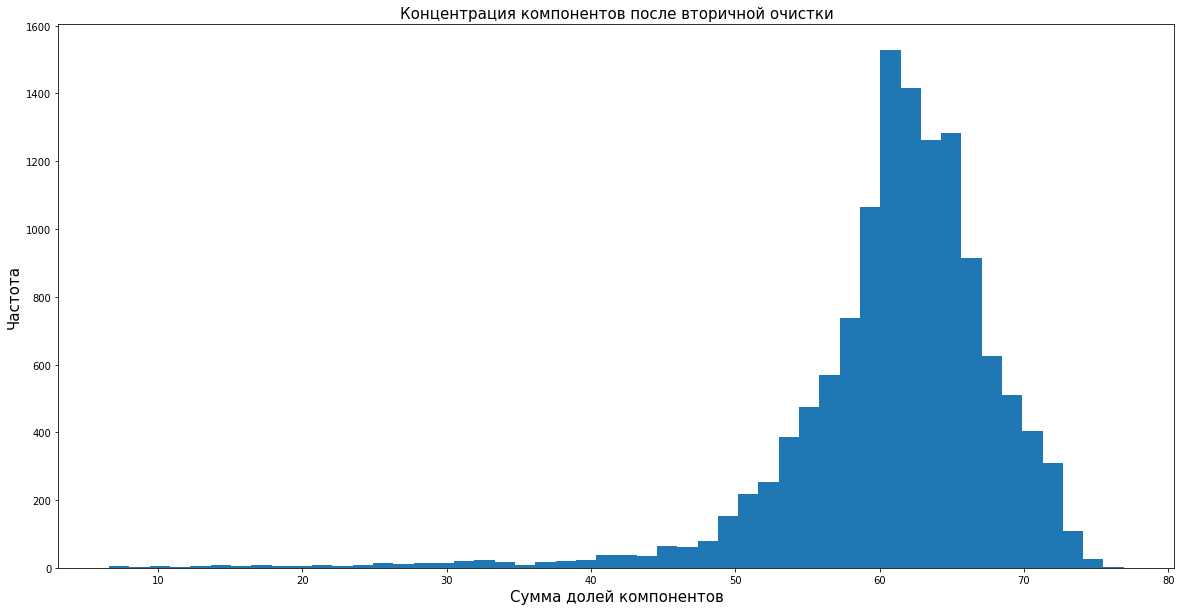

In [31]:
plt.hist(df['primary_cleaner'], bins=50)
plt.xlabel("Сумма долей компонентов", fontsize=15)
plt.title('Концентрация компонентов после вторичной очистки', fontsize=15)
plt.ylabel('Частота', fontsize=15);

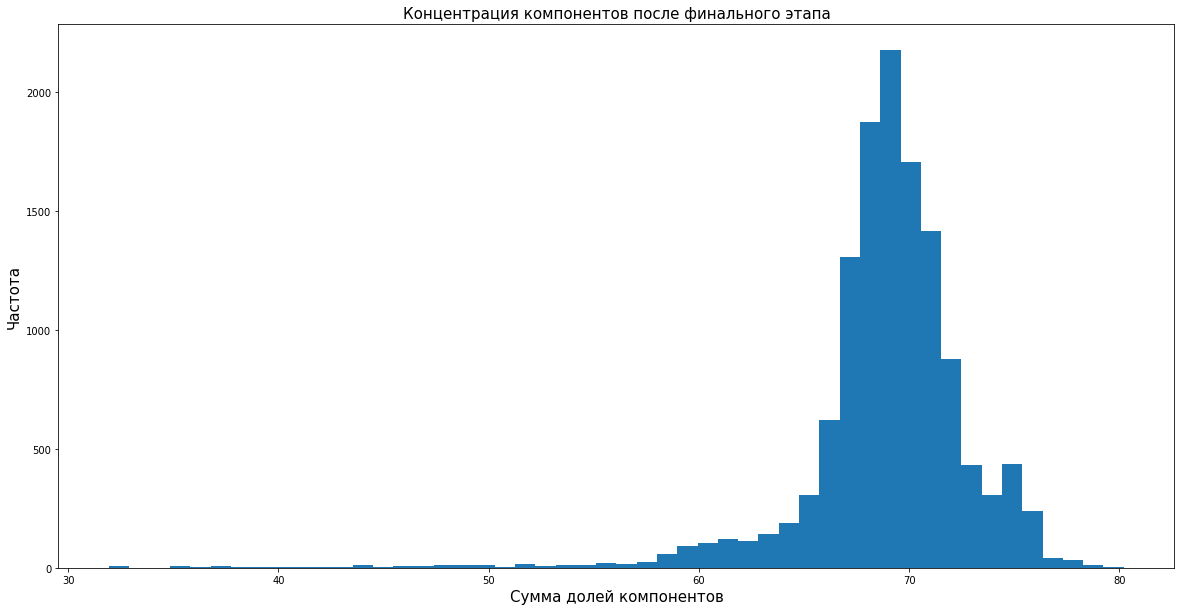

In [32]:
plt.hist(df['final.output'], bins=50)
plt.xlabel("Сумма долей компонентов", fontsize=15)
plt.title('Концентрация компонентов после финального этапа', fontsize=15)
plt.ylabel('Частота', fontsize=15);

The outliers were removed, and the pattern remained the same.

In [33]:
# Let's create the proposed features and target for training the model:
features_columns = [i for i in data_train_nodate.columns if i not in data_columns]
features_target_columns = features_columns + ['rougher.output.recovery'] + ['final.output.recovery']

In [34]:
features_columns_rougher = [i for i in features_target_columns if 'rougher.' in i]

In [35]:
features_columns_final = [i for i in features_target_columns if 'rougher.' not in i]

In [36]:
# Here is the function to find and remove highly correlated columns 
# with a correlation greater than 0.7. The function will then return 
# the remaining columns as features
def remove_correlated_columns(df):
    columns = df.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            if abs(df[columns[i]].corr(df[columns[j]])) > 0.7:
                if df[columns[i]].var() >= df[columns[j]].var():
                    df = df.drop(columns=[columns[j]])
                else:
                    df = df.drop(columns=[columns[i]])
                return remove_correlated_columns(df)
    return df

In [37]:
df_no_corr_rougher = remove_correlated_columns(data_train_nodate[features_columns_rougher])
print(len(features_columns_rougher))
len(df_no_corr_rougher.columns)

23


12

In [38]:
df_no_corr_final = remove_correlated_columns(data_train_nodate[features_columns_final])
print(len(features_columns_final))
print(len(df_no_corr_final.columns))

31
19


In [39]:
# Create the final features and target
df_no_corr_rougher = df_no_corr_rougher.dropna().reset_index(drop=True)
df_no_corr_final = df_no_corr_final.dropna().reset_index(drop=True)
df_no_corr_rougher_filtered = remove_outliers_zscore(df_no_corr_rougher.dropna().reset_index(drop=True))
df_no_corr_final_filtered = remove_outliers_zscore(df_no_corr_final.dropna().reset_index(drop=True))

In [40]:
# features and target without removing outliers
features_rougher = df_no_corr_rougher.drop('rougher.output.recovery', axis=1)
target_rougher = df_no_corr_rougher['rougher.output.recovery']
features_final = df_no_corr_final.drop('final.output.recovery', axis=1)
target_final = df_no_corr_final['final.output.recovery']

In [41]:
# features and target with outliers removed
features_rougher_no_outl = df_no_corr_rougher_filtered.drop('rougher.output.recovery', axis=1)
target_rougher_no_outl = df_no_corr_rougher_filtered['rougher.output.recovery']
features_final_no_outl = df_no_corr_final_filtered.drop('final.output.recovery', axis=1)
target_final_no_outl = df_no_corr_final_filtered['final.output.recovery']

## Модель

In [42]:
# function to calculate the Symmetric Mean Absolute Percentage Error
def sMAPE(y_true, y_pred):
    smape = 2 * abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    smape = smape.mean() * 100
    return smape
# Create our custom metric based on the function
scorer = make_scorer(sMAPE, greater_is_better=False)

In [43]:
def final_sMAPE(score_rougher, score_final):
    smape = 0.25 * score_rougher + 0.75 * score_final
    return smape

In [44]:
# First, let's test the model - Decision Tree: final stage: training data with outliers
best_score_rougher = 100
best_score_final = 100
best_model_tree = None
for depth in range(1, 10):
    model = DecisionTreeRegressor(max_depth=depth, random_state=404540)
    scores_1 = cross_val_score(model, features_rougher, target_rougher , 
                               cv=3, scoring=scorer, n_jobs=-1, verbose=10)
    scores_2 = cross_val_score(model, features_final, target_final , 
                               cv=3, scoring=scorer, n_jobs=-1, verbose=10)
    final_score_1 = - scores_1.mean()
    final_score_2 = - scores_2.mean()
    if final_score_2 < best_score_final and final_score_1 < best_score_rougher:
        best_score_final = final_score_2
        best_score_rougher = final_score_1
        best_model_tree = model
print('Финальная модель')
print(best_model_tree)
print('Финальная метрика')
final_sMAPE(best_score_rougher, best_score_final)

[CV] START .....................................................................
[CV] END .............................. score: (test=-10.947) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.028) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.146) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.224) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.954) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-12.719) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | 

[CV] END .............................. score: (test=-11.193) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.333) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.721) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.391) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.836) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.781) total time=   0.0s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.138) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.262) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.000) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.017) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.097) total time=   0.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-15.271) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-12.977) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.428) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.116) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.315) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.995) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.835) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-12.658) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.382) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-16.447) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.276) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.286) total time=   0.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-17.461) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.814) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-12.908) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-19.611) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.401) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.222) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-18.025) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-15.196) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.406) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-18.862) total time=   0.1s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END .............................. score: (test=-12.805) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.211) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-19.203) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-16.293) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.523) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-20.680) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.035) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.976) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-20.161) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.544) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-15.725) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-20.519) total time=   0.1s
Финальная модель
DecisionTreeRegressor(max_depth=1, random_state=404540)
Финальная метрика


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


11.734325612204595

In [45]:
# First, let's test the model - Decision Tree: training data without outliers
best_score_rougher = 100
best_score_final = 100
best_model_tree = None
for depth in range(1, 10):
    model = DecisionTreeRegressor(max_depth=depth, random_state=404540)
    scores_1 = cross_val_score(model, features_rougher_no_outl,
                               target_rougher_no_outl, cv=3, 
                               scoring=scorer, n_jobs=-1, verbose=10)
    scores_2 = cross_val_score(model, features_final_no_outl,
                               target_final_no_outl , cv=3, 
                               scoring=scorer, n_jobs=-1, verbose=10)
    final_score_1 = - scores_1.mean()
    final_score_2 = - scores_2.mean()
    if final_score_2 < best_score_final and final_score_1 < best_score_rougher:
        best_score_final = final_score_2
        best_score_rougher = final_score_1
        best_model_tree = model
print('Финальная модель')
print(best_model_tree)
print('Финальная метрика')
final_sMAPE(best_score_rougher, best_score_final)

[CV] START .....................................................................
[CV] END .............................. score: (test=-10.780) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.371) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.419) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.067) total time=   0.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | 

[CV] END ............................... score: (test=-9.767) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.274) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.096) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.246) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.150) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.266) total time=   0.0s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.658) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.433) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.563) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.777) total time=   0.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.268) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.628) total time=   0.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.394) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.613) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.505) total time=   0.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.707) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.333) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.683) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-12.960) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.238) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.964) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.482) total time=   0.0s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


[CV] START .....................................................................
[CV] END .............................. score: (test=-13.646) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.311) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-12.668) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.349) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.335) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-6.644) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.025) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.543) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.806) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.495) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.897) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.676) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.145) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.989) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.522) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.595) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.340) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-8.066) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.426) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.115) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-18.511) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.465) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.551) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.311) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.406) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.361) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-17.637) total time=   0.1s
Финальная модель
DecisionTreeRegressor(max_depth=1, random_state=404540)
Финальная метрика


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


9.824735908262303

In [46]:
# Let's test the linear model, 
# but first we need to scale the data
scaler = StandardScaler()
features_rougher_sc = scaler.fit_transform(features_rougher)
features_final_sc = scaler.fit_transform(features_final)
features_rougher_no_outl_sc = scaler.fit_transform(features_rougher_no_outl)
features_final_no_outl_sc = scaler.fit_transform(features_final_no_outl)

In [53]:
model_linear = LinearRegression()
scores_1 = cross_val_score(model, features_rougher_sc, target_rougher, cv=5, scoring=scorer)
scores_2 = cross_val_score(model, features_final_sc, target_final, cv=5, scoring=scorer)
print('Финальная метрика')
final_sMAPE( - scores_1.mean(), - scores_2.mean())

Финальная метрика


11.244661214120507

In [54]:
model = LinearRegression()
scores_1 = cross_val_score(model, features_rougher_no_outl_sc, target_rougher_no_outl, cv=5, scoring=scorer)
scores_2 = cross_val_score(model, features_final_no_outl_sc, target_final_no_outl, cv=5, scoring=scorer)
print('Финальная метрика')
final_sMAPE(-scores_1.mean(), -scores_2.mean())

Финальная метрика


8.755396421265115

In [90]:
# Test the model - Random Forest: training data with outliers
best_score_rougher_1 = 100
best_score_final_1 = 100
best_model_forest_1 = None
for depth in range(1, 11):
    for est in range(10, 151, 10):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=404540)
        scores_1 = cross_val_score(model, features_rougher,
                                   target_rougher, cv=3, scoring=scorer,
                                   n_jobs=-1, verbose=10)
        scores_2 = cross_val_score(model, features_final,
                                   target_final, cv=3, scoring=scorer,
                                   n_jobs=-1, verbose=10)
        final_score_1 = - scores_1.mean()
        final_score_2 = - scores_2.mean()
        if final_score_2 < best_score_final_1 and final_score_1 < best_score_rougher_1:
            best_score_final_1 = final_score_2
            best_score_rougher_1 = final_score_1
            best_model_forest_1 = model
print('Финальная модель')
print(best_model_forest_1)
print('Финальная метрика')
final_sMAPE(best_score_rougher_1, best_score_final_1)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] START .....................................................................
[CV] END .............................. score: (test=-10.929) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.005) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-15.164) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.083) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.824) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-12.020) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.942) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.048) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-15.166) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.084) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.798) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.184) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.940) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.032) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.161) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.081) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.811) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-12.225) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.940) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.015) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-15.152) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.082) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.819) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.310) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.953) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.014) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.149) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.082) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.818) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.324) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.945) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.008) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-15.152) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.081) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.819) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-12.241) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.935) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.003) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-15.144) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.081) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.824) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-12.218) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.934) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.006) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-15.144) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.080) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.821) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.262) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.935) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.006) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-15.142) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.081) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.820) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-12.265) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.934) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.009) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-15.143) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.081) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.821) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.275) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.937) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.007) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.135) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.078) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.821) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-12.291) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.936) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.011) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-15.140) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.076) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.824) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.274) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.933) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.009) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-15.139) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.074) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.821) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.261) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.932) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.011) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-15.141) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.073) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.818) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.274) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.933) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.012) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-15.140) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.074) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.819) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.266) total time=   1.6s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.062) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.291) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-14.722) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.427) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.441) total time=   0.2s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.425) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.136) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.326) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.747) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.464) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.176) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.486) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.094) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.320) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.739) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.472) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.159) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.197) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.075) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.306) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.734) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.416) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.223) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.875) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.101) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.301) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.731) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.450) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.197) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.855) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.101) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.195) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.734) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.443) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.215) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.035) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.108) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.214) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.728) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.464) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.210) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.075) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.104) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.231) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.729) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.460) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.176) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.017) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.103) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.242) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.729) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.484) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.203) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.061) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.113) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.253) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.729) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.500) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.177) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.119) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.097) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.262) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.722) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.481) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.176) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.060) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.089) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.266) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.726) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.474) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.176) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.076) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.091) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.274) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.726) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.454) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.184) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.116) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.088) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.275) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-14.729) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.459) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.167) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.102) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.077) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.281) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.727) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.457) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.180) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.087) total time=   3.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.399) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.102) total time=   0.2s
[CV] START .....................................................................
[CV] END .............................. score: (test=-13.635) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.572) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.713) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.078) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.511) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.143) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.716) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.298) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.396) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.107) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.493) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.138) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.715) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.035) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.339) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.980) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.522) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.195) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.710) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.968) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.392) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.943) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.529) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.182) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.691) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.958) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.368) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.912) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.548) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.168) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.723) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.955) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.404) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.906) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.556) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.189) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.679) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.975) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.366) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.876) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.537) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.209) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.689) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.030) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.352) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.879) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.545) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.227) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.682) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.974) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.374) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.852) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.560) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.244) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.686) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.919) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.361) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.854) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.548) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.248) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.654) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.884) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.362) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.852) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.518) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.243) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.679) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.865) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.360) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.863) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.530) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.245) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.657) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.883) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.356) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.883) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.518) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.232) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.652) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.896) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.346) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.902) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.496) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.234) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.673) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.889) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.350) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.894) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.183) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.884) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.379) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.180) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.702) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.248) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.144) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.878) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.615) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.367) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.564) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.984) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.978) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.774) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.889) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.192) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.568) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.900) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.994) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.723) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.978) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.991) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.568) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.898) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.995) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.641) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.940) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.938) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.547) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.840) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.097) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.651) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.888) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.876) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.581) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.868) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.045) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.652) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.786) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.799) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.570) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.939) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.019) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.646) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.943) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.920) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.552) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.890) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.018) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.677) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.871) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.805) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.568) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.865) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.025) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.694) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-15.009) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.732) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.544) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.027) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.024) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.701) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.857) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.735) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.551) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.999) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.999) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.727) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.890) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.697) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.525) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.964) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.998) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.730) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.832) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.721) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.484) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.985) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.999) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.693) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.841) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.744) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.482) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.981) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.982) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.689) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.885) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.756) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.489) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.953) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.666) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.016) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-15.525) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.404) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.207) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.825) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.756) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.771) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.980) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.859) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.954) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.193) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.546) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.653) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.751) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.515) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.875) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.104) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.510) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.584) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.981) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.342) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.852) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.093) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.496) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.528) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.002) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.275) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.818) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.024) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.541) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.543) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-15.067) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.156) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.856) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.996) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.495) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.595) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.842) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.093) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.847) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.151) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.535) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.581) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] END .............................. score: (test=-15.234) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.257) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.840) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.128) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.582) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.603) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV] END .............................. score: (test=-15.096) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.118) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.857) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.062) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.608) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.581) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.088) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.998) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.823) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.199) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.644) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.601) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.907) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.083) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.817) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.166) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.613) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.608) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.961) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.009) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.772) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.116) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.594) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.591) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.911) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.016) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.777) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.162) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.581) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.567) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.813) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.038) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.772) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.160) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.571) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.572) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.880) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.084) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.785) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.125) total time=   6.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.492) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.405) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-15.471) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.136) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.460) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.505) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.533) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.516) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-15.484) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.616) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.104) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.187) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.422) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.440) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-15.670) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.628) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.001) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.063) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.326) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.379) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-16.211) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.552) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.988) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.389) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.266) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.420) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-16.272) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.470) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.961) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.263) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.339) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.462) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-16.543) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.388) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.037) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.244) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.289) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.558) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] END .............................. score: (test=-16.126) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.328) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-12.003) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.377) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.319) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.558) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-16.294) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.540) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.989) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.403) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.345) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.590) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-16.287) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.373) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END .............................. score: (test=-12.013) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.310) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.397) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.571) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] END .............................. score: (test=-16.305) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.211) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.977) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.374) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.454) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.596) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


[CV] END .............................. score: (test=-16.079) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.297) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.976) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.393) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.440) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.646) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] END .............................. score: (test=-16.038) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.196) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.949) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.330) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.406) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.614) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV] END .............................. score: (test=-15.865) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.227) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.910) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.363) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.391) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.573) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


[CV] END .............................. score: (test=-15.757) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.252) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.909) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.396) total time=   7.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.370) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.586) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


[CV] END .............................. score: (test=-15.847) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.284) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.930) total time=   7.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.359) total time=   8.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.128) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-14.099) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-15.495) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.749) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-12.195) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.753) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.000) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.667) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-16.650) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.335) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.303) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-14.586) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.592) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.595) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-16.760) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.258) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.183) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.464) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.544) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.520) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-16.816) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.110) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-12.050) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.652) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.588) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.542) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-16.901) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.038) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.033) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.406) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.532) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.528) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-17.039) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.921) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.050) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.298) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.385) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.611) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-16.686) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.804) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.051) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.433) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.401) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.608) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-16.685) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.044) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.048) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.568) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.430) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.649) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-17.313) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.810) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] END .............................. score: (test=-12.081) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.492) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.455) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.611) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


[CV] END .............................. score: (test=-17.341) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.709) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.040) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.537) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.517) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.635) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s


[CV] END .............................. score: (test=-17.004) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.777) total time=   6.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-12.059) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.585) total time=   6.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.450) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.654) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


[CV] END .............................. score: (test=-16.861) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.698) total time=   7.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] END .............................. score: (test=-12.010) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.484) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.391) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.629) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV] END .............................. score: (test=-16.723) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.731) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.965) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV] END .............................. score: (test=-14.541) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.419) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.592) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV] END .............................. score: (test=-16.613) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.727) total time=   8.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.965) total time=   8.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.574) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.398) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.623) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s


[CV] END .............................. score: (test=-16.632) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.762) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.987) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.536) total time=   9.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.361) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-14.686) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-15.624) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-15.434) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-12.535) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-15.547) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.129) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.165) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-16.932) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.491) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-12.423) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.994) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.592) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.749) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-17.547) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.095) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.179) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.836) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.547) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.628) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-17.285) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.978) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.929) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.033) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.546) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.648) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-17.348) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.260) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.978) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.819) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.516) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.687) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV] END .............................. score: (test=-17.621) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.332) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.940) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.660) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.401) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.710) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV] END .............................. score: (test=-17.105) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.066) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.980) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


[CV] END .............................. score: (test=-14.706) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.480) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.712) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV] END .............................. score: (test=-17.205) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.413) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.964) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.831) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.511) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.709) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


[CV] END .............................. score: (test=-17.640) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.163) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.008) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.763) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.546) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.720) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV] END .............................. score: (test=-17.461) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.161) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.997) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.839) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.582) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.755) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


[CV] END .............................. score: (test=-17.182) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.225) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] END .............................. score: (test=-12.025) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.871) total time=   7.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.535) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.720) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s


[CV] END .............................. score: (test=-17.128) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.113) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.999) total time=   7.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.757) total time=   8.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.490) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.692) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s


[CV] END .............................. score: (test=-17.092) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.131) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.953) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.769) total time=   9.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.460) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.644) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s


[CV] END .............................. score: (test=-17.019) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.159) total time=   9.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.931) total time=   9.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   18.8s remaining:    0.0s


[CV] END .............................. score: (test=-14.806) total time=   9.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.432) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.689) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


[CV] END .............................. score: (test=-17.108) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.221) total time=  10.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.979) total time=   9.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.760) total time=  10.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.234) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.190) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-15.780) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-15.393) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.386) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.211) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.854) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.184) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-17.073) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.585) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.389) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.940) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.378) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.840) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-18.002) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.188) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.179) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.884) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.359) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.681) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-17.935) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-13.953) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.089) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] END .............................. score: (test=-15.056) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.350) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.670) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-17.982) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.244) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.050) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.892) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.463) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.699) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] END .............................. score: (test=-18.508) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.471) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.987) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


[CV] END .............................. score: (test=-14.775) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.398) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.733) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] END .............................. score: (test=-17.993) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.226) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] END .............................. score: (test=-12.009) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.934) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.451) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.691) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-18.289) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.408) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.975) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.016) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.474) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.651) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV] END .............................. score: (test=-18.822) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.112) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.063) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.987) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.558) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.621) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV] END .............................. score: (test=-18.658) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.038) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.022) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV] END .............................. score: (test=-15.008) total time=   7.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.542) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.644) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s


[CV] END .............................. score: (test=-18.306) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.173) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.087) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV] END .............................. score: (test=-15.013) total time=   7.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.489) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.632) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV] END .............................. score: (test=-18.144) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.032) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] END .............................. score: (test=-12.102) total time=   8.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.847) total time=   8.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.435) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.611) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s


[CV] END .............................. score: (test=-18.211) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.095) total time=   9.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] END .............................. score: (test=-12.035) total time=   9.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.848) total time=   9.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.437) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.583) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s


[CV] END .............................. score: (test=-18.100) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.096) total time=  10.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] END .............................. score: (test=-12.014) total time=   9.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.0s remaining:    0.0s


[CV] END .............................. score: (test=-14.877) total time=  10.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.480) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.613) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV] END .............................. score: (test=-18.212) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.132) total time=  10.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV] END .............................. score: (test=-12.076) total time=  11.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   21.9s remaining:    0.0s


[CV] END .............................. score: (test=-14.831) total time=  10.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.626) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-14.040) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-16.565) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-15.801) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.567) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.968) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.583) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.827) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-17.835) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.918) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-12.431) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-15.466) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.873) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.467) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-18.826) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.779) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-12.129) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] END .............................. score: (test=-15.119) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.689) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.460) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-18.382) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.520) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.909) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] END .............................. score: (test=-15.211) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.554) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.481) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV] END .............................. score: (test=-18.270) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.686) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.898) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV] END .............................. score: (test=-15.069) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.603) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.487) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] END .............................. score: (test=-18.201) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.561) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.855) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.901) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.463) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.542) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV] END .............................. score: (test=-17.714) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.370) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.896) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s


[CV] END .............................. score: (test=-15.025) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.496) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.544) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] END .............................. score: (test=-17.881) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.582) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.927) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s


[CV] END .............................. score: (test=-15.094) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.443) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.586) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV] END .............................. score: (test=-18.442) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.252) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-12.006) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s


[CV] END .............................. score: (test=-15.086) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.482) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.579) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


[CV] END .............................. score: (test=-18.472) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.105) total time=   7.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.962) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.161) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.529) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.567) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s


[CV] END .............................. score: (test=-18.338) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.264) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.989) total time=   8.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[CV] END .............................. score: (test=-15.158) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.472) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.559) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s


[CV] END .............................. score: (test=-18.326) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.058) total time=   9.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.998) total time=   9.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   18.9s remaining:    0.0s


[CV] END .............................. score: (test=-15.041) total time=   9.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.419) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.536) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s


[CV] END .............................. score: (test=-18.228) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.105) total time=  10.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] END .............................. score: (test=-11.930) total time=  10.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s


[CV] END .............................. score: (test=-15.065) total time=  10.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.426) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.472) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV] END .............................. score: (test=-18.059) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.129) total time=  11.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.938) total time=  10.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s


[CV] END .............................. score: (test=-15.081) total time=  11.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.450) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.509) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] END .............................. score: (test=-18.056) total time=   7.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-14.209) total time=  12.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


[CV] END .............................. score: (test=-12.036) total time=  11.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.7s remaining:    0.0s


[CV] END .............................. score: (test=-15.013) total time=  12.5s
Финальная модель
RandomForestRegressor(max_depth=1, n_estimators=10, random_state=404540)
Финальная метрика


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.2s finished


11.4897543272843

In [91]:
# Test the model - Random Forest: training data without outliers
best_score_rougher_2 = 100
best_score_final_2 = 100
best_model_forest_2 = None
for depth in range(1, 11):
    for est in range(10, 151, 10):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=404540)
        scores_1 = cross_val_score(model, features_rougher_no_outl,
                                   target_rougher_no_outl, cv=3, scoring=scorer,
                                   n_jobs=-1, verbose=10)
        scores_2 = cross_val_score(model, features_final_no_outl,
                                   target_final_no_outl , cv=3, scoring=scorer,
                                   n_jobs=-1, verbose=10)
        final_score_1 = - scores_1.mean()
        final_score_2 = - scores_2.mean()
        if final_score_2 < best_score_final_2 and final_score_1 < best_score_rougher_2:
            best_score_final_2 = final_score_2
            best_score_rougher_2 = final_score_1
            best_model_forest_2 = model
print('Финальная модель')
print(best_model_forest_2)
print('Финальная метрика')
final_sMAPE(best_score_rougher_2, best_score_final_2)

[CV] START .....................................................................
[CV] END .............................. score: (test=-10.649) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.375) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.457) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.279) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.445) total time=   0.1s
[CV] START .....................................................................
[CV] END .............................. score: (test=-11.179) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.709) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.373) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.506) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.251) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.453) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.217) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.686) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.378) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.501) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.374) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.475) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.198) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.672) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.372) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.494) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.337) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.482) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.204) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.692) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.365) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.494) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.379) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.475) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.201) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.707) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.366) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.516) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.378) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.468) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-11.203) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.718) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.368) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-9.502) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.354) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.478) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-11.193) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.686) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.365) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.504) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.359) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-9.486) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-11.187) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.680) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.367) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.504) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.336) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-9.491) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.188) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.676) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.368) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-9.504) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.349) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.488) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-11.188) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.685) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.367) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.492) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.338) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-9.497) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-11.189) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.693) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.366) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.497) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.328) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.488) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-11.191) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.688) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.367) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-9.492) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.350) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-9.490) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-11.191) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.696) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.369) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-9.492) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.344) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.488) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-11.187) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.691) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.368) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-9.486) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.336) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-9.489) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-11.180) total time=   1.6s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.067) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.551) total time=   0.1s
[CV] START .....................................................................
[CV] END ............................... score: (test=-7.278) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.379) total time=   0.2s
[CV] START .....................................................................
[CV] END .............................. score: (test=-10.122) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.515) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.075) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.760) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.275) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.333) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.035) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.623) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.074) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.740) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.293) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.370) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.098) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.552) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.059) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.787) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.286) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.323) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.072) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.550) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.064) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.725) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.277) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.362) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.051) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.541) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.065) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.722) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.327) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.361) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.043) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.549) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.066) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.681) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.300) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.345) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.058) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.527) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.051) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.716) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.301) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.354) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.050) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.523) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.055) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.773) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.331) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.338) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.034) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.522) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.056) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.764) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.326) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.340) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.024) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.521) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.059) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.776) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.324) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.335) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.019) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.518) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.061) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.750) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.325) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.332) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.023) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.523) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.059) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.767) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.331) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.338) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.020) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.523) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.063) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-5.800) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.323) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.334) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.014) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.521) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.061) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.798) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.323) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.333) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.018) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.517) total time=   2.8s
[CV] START .....................................................................
[CV] END ............................... score: (test=-9.498) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.808) total time=   0.2s
[CV] START .....................................................................
[CV] END ............................... score: (test=-6.705) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.839) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.259) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.245) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.521) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.010) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-6.590) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.694) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.190) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.311) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.522) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.960) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-6.655) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.699) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.218) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.230) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.538) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-6.042) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.684) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.697) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.193) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.210) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.527) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-6.047) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-6.688) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.726) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.197) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.187) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.523) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-6.020) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END ............................... score: (test=-6.650) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.726) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.185) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.192) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.518) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-6.012) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.645) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.717) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.213) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.178) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.523) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-6.020) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END ............................... score: (test=-6.663) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.759) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.193) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.182) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.540) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-6.066) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] END ............................... score: (test=-6.691) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.758) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.183) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.188) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.545) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-6.053) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.683) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.745) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.163) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.186) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.542) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-6.046) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END ............................... score: (test=-6.695) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.753) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.156) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.191) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.538) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-6.046) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END ............................... score: (test=-6.695) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.744) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.156) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.193) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.540) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-6.061) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] END ............................... score: (test=-6.709) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.729) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.142) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.196) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.535) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-6.071) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV] END ............................... score: (test=-6.714) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.727) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.141) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.195) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.528) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END ............................... score: (test=-6.063) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] END ............................... score: (test=-6.713) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.723) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.146) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.192) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.600) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.774) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.138) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.530) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.393) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-12.919) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.445) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.974) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.216) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.253) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.207) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.139) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.356) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-5.986) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.152) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.993) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.272) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.086) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.345) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-5.999) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.142) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.039) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.311) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.103) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.346) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-6.005) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.055) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.131) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.293) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.075) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.334) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.952) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.042) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.075) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.265) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.081) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.345) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.962) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.048) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.000) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.263) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.072) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.345) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.984) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.039) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.103) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.240) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.077) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.359) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-6.014) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.062) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.076) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.239) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.079) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.345) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-6.000) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.051) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.009) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.211) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.083) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.344) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.966) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.037) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.990) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.211) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.102) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.343) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.984) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.053) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.007) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.205) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.111) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.340) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END ............................... score: (test=-5.996) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.043) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.997) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.196) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.106) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.346) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END ............................... score: (test=-6.010) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.042) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.026) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.200) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.111) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.340) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.001) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.030) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.971) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.216) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.111) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.626) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-6.088) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.580) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.586) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.654) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.187) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.330) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-6.039) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.660) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.349) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.484) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.140) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.273) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.950) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.630) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.409) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.505) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.158) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.242) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.960) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.658) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.493) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.488) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.137) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.231) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.977) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.533) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.477) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.481) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.056) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.218) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.949) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.472) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.316) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.492) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.088) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.218) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.973) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.410) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.182) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.485) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.080) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.232) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.985) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.393) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.264) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.439) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.065) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.240) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.959) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.399) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.254) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.454) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.023) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.232) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END ............................... score: (test=-5.945) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.365) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.126) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.427) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.021) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.215) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.895) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.340) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.115) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.414) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.021) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.202) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.901) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.285) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.075) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.407) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.050) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.213) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.899) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.259) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.074) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.392) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.027) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.206) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] END ............................... score: (test=-5.906) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.260) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.098) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.407) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.042) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.195) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.904) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.267) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.038) total time=   6.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.420) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.086) total time=   6.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.544) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-6.084) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.894) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.307) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.721) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.369) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.326) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-5.947) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.630) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.067) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.445) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.298) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.253) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-5.873) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.660) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.070) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.568) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.461) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.208) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.790) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.676) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.110) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.548) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.477) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.194) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.777) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.555) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.082) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.491) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.332) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.174) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.720) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.510) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.993) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.542) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.382) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.168) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.792) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.414) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.935) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.542) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.320) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.173) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.813) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.416) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.981) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.506) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.340) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.201) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.827) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.497) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.010) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.527) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.300) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.192) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.805) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.468) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.865) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.491) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.301) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.179) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.730) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.428) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.842) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.464) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.312) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.166) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.736) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.419) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.772) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.439) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.320) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.171) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.741) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.366) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.796) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.428) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.314) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.149) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.763) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.324) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.839) total time=   7.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.454) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.320) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.141) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] END ............................... score: (test=-5.799) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.322) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.723) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.462) total time=   8.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.351) total time=   7.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.418) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.716) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-8.122) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.243) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.525) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.921) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.207) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.699) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.800) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.118) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.521) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.717) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.155) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.726) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-7.900) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.249) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.592) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.804) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.129) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.686) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.974) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.207) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.542) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.790) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.102) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.694) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.860) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.157) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.556) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.602) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.078) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.638) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.817) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.223) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.657) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.618) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.098) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.667) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.743) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.130) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.671) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.520) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.120) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.741) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.685) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.207) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.649) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.633) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.140) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.704) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.745) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.202) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.673) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.611) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.133) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.704) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.675) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.108) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.637) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.586) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.115) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.639) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] END ............................... score: (test=-7.616) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.083) total time=   6.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.622) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.620) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.108) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.671) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.614) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.056) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.584) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.613) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.106) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.697) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.590) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.083) total time=   7.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.600) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.617) total time=   7.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.094) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.713) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s


[CV] END ............................... score: (test=-7.570) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.093) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.603) total time=   7.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.583) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.091) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.763) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.579) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-10.965) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.575) total time=   8.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.599) total time=   8.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.592) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.017) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.566) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.530) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.616) total time=   0.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-14.106) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.303) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.746) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-8.083) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.379) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.625) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.623) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.224) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.653) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] END ............................... score: (test=-8.153) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.866) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.775) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.634) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.133) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.624) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.128) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.673) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.687) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.748) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.100) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-5.667) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.017) total time=   2.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.698) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.704) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.639) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.055) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.644) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] END ............................... score: (test=-8.029) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.634) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.786) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.632) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.054) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.698) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.912) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.493) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.782) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.544) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.044) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.727) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.895) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.451) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.765) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.658) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.067) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.661) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] END ............................... score: (test=-7.971) total time=   3.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.488) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] END .............................. score: (test=-10.777) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.637) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.066) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.674) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.896) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.430) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.747) total time=   6.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.650) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.061) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.606) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.873) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.385) total time=   7.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.701) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.658) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.047) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] END ............................... score: (test=-5.632) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV] END ............................... score: (test=-7.880) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.340) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.672) total time=   7.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.627) total time=   7.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.044) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.631) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s


[CV] END ............................... score: (test=-7.843) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.326) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.711) total time=   8.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.633) total time=   8.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.037) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.666) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.803) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.319) total time=   9.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] END .............................. score: (test=-10.735) total time=   9.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   18.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.620) total time=   9.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.039) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.708) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s


[CV] END ............................... score: (test=-7.821) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.172) total time=  10.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.711) total time=  10.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.628) total time=  10.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.485) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.603) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END ............................... score: (test=-8.276) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.810) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.495) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV] END .............................. score: (test=-14.100) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.205) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.575) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.061) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.497) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.704) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.702) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.094) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.645) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] END ............................... score: (test=-8.106) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.685) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.917) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.800) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.017) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-5.607) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] END ............................... score: (test=-8.186) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.602) total time=   3.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.844) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.930) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.995) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.632) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.075) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.636) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.867) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.729) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.962) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.628) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] END ............................... score: (test=-8.122) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.619) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.925) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.761) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.964) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.653) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.048) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.545) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.896) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.634) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.958) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.724) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.041) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.553) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.880) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.744) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.993) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.696) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.127) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.576) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.887) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.650) total time=   6.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.983) total time=   4.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.707) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.050) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.495) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.871) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.683) total time=   6.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.965) total time=   4.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.650) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.020) total time=   4.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.464) total time=   7.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.813) total time=   7.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.680) total time=   7.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.957) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.675) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.025) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.430) total time=   8.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.767) total time=   8.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.708) total time=   8.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.946) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.700) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s


[CV] END ............................... score: (test=-7.998) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.446) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.835) total time=   8.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.717) total time=   8.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.949) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.728) total time=   5.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV] END ............................... score: (test=-7.968) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.436) total time=   9.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] END .............................. score: (test=-10.862) total time=   9.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   18.7s remaining:    0.0s


[CV] END .............................. score: (test=-13.713) total time=   9.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.949) total time=   6.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.799) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s


[CV] END ............................... score: (test=-7.974) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.290) total time=  10.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.849) total time=  10.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.707) total time=  10.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.350) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-6.066) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.365) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-12.091) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.102) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-14.198) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.172) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-5.728) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.170) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.469) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.466) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] END .............................. score: (test=-13.817) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-9.027) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ............................... score: (test=-5.632) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END ............................... score: (test=-8.226) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.935) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.752) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.669) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.980) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] END ............................... score: (test=-5.638) total time=   1.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] END ............................... score: (test=-8.228) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.752) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END .............................. score: (test=-10.688) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV] END .............................. score: (test=-13.870) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.936) total time=   2.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.671) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.116) total time=   2.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.674) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.734) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.653) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.877) total time=   2.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.638) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.194) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.687) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END .............................. score: (test=-10.726) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.648) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.867) total time=   3.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END ............................... score: (test=-5.676) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.105) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.559) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.798) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV] END .............................. score: (test=-13.568) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.847) total time=   3.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.744) total time=   3.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.086) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.487) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] END .............................. score: (test=-10.815) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.765) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.897) total time=   4.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END ............................... score: (test=-5.689) total time=   3.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV] END ............................... score: (test=-8.136) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.524) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.838) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s


[CV] END .............................. score: (test=-13.691) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.899) total time=   4.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] END ............................... score: (test=-5.688) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


[CV] END ............................... score: (test=-8.064) total time=   4.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.387) total time=   7.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] END .............................. score: (test=-10.863) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.782) total time=   7.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.888) total time=   4.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] END ............................... score: (test=-5.624) total time=   4.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV] END ............................... score: (test=-8.060) total time=   4.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.334) total time=   8.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.868) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s


[CV] END .............................. score: (test=-13.776) total time=   8.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.883) total time=   5.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END ............................... score: (test=-5.642) total time=   5.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV] END ............................... score: (test=-8.090) total time=   5.0s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.310) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] END .............................. score: (test=-10.845) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   17.6s remaining:    0.0s


[CV] END .............................. score: (test=-13.768) total time=   8.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.873) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] END ............................... score: (test=-5.632) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.052) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.343) total time=   9.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.893) total time=   9.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.1s remaining:    0.0s


[CV] END .............................. score: (test=-13.766) total time=   9.7s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.868) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] END ............................... score: (test=-5.673) total time=   6.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s


[CV] END ............................... score: (test=-8.027) total time=   5.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.346) total time=  10.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV] END .............................. score: (test=-10.896) total time=   9.9s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s


[CV] END .............................. score: (test=-13.768) total time=  10.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-8.865) total time=   6.6s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] END ............................... score: (test=-5.719) total time=   6.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s


[CV] END ............................... score: (test=-8.050) total time=   6.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .............................. score: (test=-11.193) total time=  11.2s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] END .............................. score: (test=-10.884) total time=  10.8s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.759) total time=  10.9s
Финальная модель
RandomForestRegressor(max_depth=1, n_estimators=10, random_state=404540)
Финальная метрика


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.9s finished


9.765936575470556

In [78]:
# Testing on the test set:
data_test_full = pd.merge(data_test, data_full[['rougher.output.recovery', 'final.output.recovery', 'date']], on='date').dropna().reset_index(drop=True)
features_test_rougher = data_test_full.loc[:, features_rougher.columns]  
target_test_rougher = data_test_full.loc[:, target_rougher.name]
features_test_final = data_test_full.loc[:, features_final.columns]
target_test_final = data_test_full.loc[:, target_final.name]

The Random Forest model performed well on the dataset without outliers. Let's test it on the test set.

In [89]:
# Random forest
best_model_forest_1.fit(features_rougher_no_outl, target_rougher_no_outl)
rougher = best_model_forest_1.predict(features_test_rougher)
best_model_forest_1.fit(features_final_no_outl, target_final_no_outl)
final = best_model_forest_1.predict(features_test_final)
print(final_sMAPE(sMAPE(target_test_rougher, rougher), sMAPE(target_test_final, final)))

9.000377956897783


In [84]:
# Dummy model
dummy = DummyRegressor(strategy='me')
dummy.fit(features_rougher_no_outl, target_rougher_no_outl)
rougher = dummy.predict(features_test_rougher)
dummy.fit(features_final_no_outl, target_final_no_outl)
final = dummy.predict(features_test_final)
print(final_sMAPE(sMAPE(target_test_rougher, rougher), sMAPE(target_test_final, final)))

9.291636018994835


**Conclusion:**

The recovery parameter was calculated correctly. The test set lacked columns with target features, all types of output and calculate parameters, totaling about 34 columns. The concentration of metals during the gold purification process changes unevenly: the fraction of silver decreases, the fraction of lead slightly increases, and the fraction of gold significantly increases. The distribution of ore granules in the training and test sets is similar. The distribution of the total amount of substances throughout the purification process tends to converge to a single average value.

The best model was achieved using the RandomForest algorithm, with a key metric of 11.4 on the test set, which can be considered a good result. The model's hyperparameters are: `RandomForestRegressor(max_depth=1, n_estimators=2, random_state=404540)`.